# This is a notebook to compare histograms of crops across a region containing multiple logical patches

## Import dependencies

In [1]:
from pathlib import Path
from glob import glob
import netCDF4
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from utils import CROP_ENCODING

## A function to produce monthly band data for the growing season

In [2]:
def monthly_band_data(band, year):

    # Or maybe aggregate based on a given frequency
    # Refer to
    # https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
    group_freq = '1MS'
    
    # output intervals
    date_range = pd.date_range(start=f'{year}-01-01', end=f'{int(year) + 1}-01-01', freq=group_freq)

    band_data = band.groupby_bins(
        'time',
        bins=date_range,
        right=True,
        include_lowest=False,
        labels=date_range[:-1]
    ).mean(dim='time').interpolate_na(
        dim='time_bins', method='linear', fill_value='extrapolate'
    )[3:9]

    return band_data

In [3]:
def decode_labels(labels):
    CROP_DECODING = dict((v,k) for k, v in CROP_ENCODING.items())
    CROP_DECODING[0] = "UNDEFINED"
    return np.vectorize(CROP_DECODING.get)(labels)

def decode_label(label):
    return decode_labels(label)

In [7]:
def rgb2d(B02, B03, B04, time=0):
    return np.dstack((
            np.array((B04.isel(time=time) / 16).astype(np.uint8)),
            np.array((B03.isel(time=time) / 16).astype(np.uint8)),
            np.array((B02.isel(time=time) / 16).astype(np.uint8))
    )).copy()

In [8]:
def load_patch_file(patch_file):
    patch = netCDF4.Dataset(Path(patch_file), 'r')
    print(f'patch file "{patch_file}" contains patch data from {patch.patch_name}')
    B02 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B02'])).B02
    B03 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B03'])).B03
    B04 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B04'])).B04
    B08 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B08'])).B08
    patch_data = {
        'B02':  {
            'title': 'B02 - Blue',
            'band': B02,
            'uint8': np.array((B02 / 16).astype(np.uint8)),
            'monthly': monthly_band_data(B02, patch.patch_year),
            'plotc': 'b'
            },
        'B03': {
            'title': 'B03 - Green',
            'band': B03,
            'uint8': np.array((B03 / 16).astype(np.uint8)),
            'monthly': monthly_band_data(B03, patch.patch_year),
            'plotc': 'g'
        },
        'B04':   {
            'title': 'B04 - Red',
            'band': B04,
            'uint8': np.array((B04 / 16).astype(np.uint8)),
            'monthly': monthly_band_data(B04, patch.patch_year),
            'plotc': 'r'
        },
        'B08':   {
            'title': 'B08 - NIR',
            'band': B08,
            'uint8': np.array((B08 / 16).astype(np.uint8)),
            'monthly': monthly_band_data(B08, patch.patch_year),
            'plotc': 'y'
        },
        'parcels': xr.open_dataset(xr.backends.NetCDF4DataStore(patch['parcels'])),
        'labels': xr.open_dataset(xr.backends.NetCDF4DataStore(patch['labels'])),
        'name': patch.patch_full_name,
        'file': patch_file,
        'year': patch.patch_year,
        'patch_country_code': patch.patch_country_code,
        'rgbt0': rgb2d(B02, B03, B04, time=0)
    }
    return patch, patch_data

files = sorted(glob('dataset/netcdf/*.nc'))
print(f'{len(files)} NetCDF4 files')
print(files[0:5])
%time patch0, patch_data0 = load_patch_file(files[5])
patch0

754 NetCDF4 files
['dataset/netcdf/2019_31TBF_patch_17_11.nc', 'dataset/netcdf/2019_31TBF_patch_17_12.nc', 'dataset/netcdf/2019_31TBF_patch_17_13.nc', 'dataset/netcdf/2019_31TBF_patch_18_11.nc', 'dataset/netcdf/2019_31TBF_patch_18_12.nc']
patch file "dataset/netcdf/2019_31TBF_patch_18_13.nc" contains patch data from patch_18_13
CPU times: user 9.45 s, sys: 83.4 ms, total: 9.53 s
Wall time: 9.62 s


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: S4A Patch Dataset
    authors: Papoutsis I., Sykas D., Zografakis D., Sdraka M.
    patch_full_name: 2019_31TBF_patch_18_13
    patch_year: 2019
    patch_name: patch_18_13
    patch_country_code: ES
    patch_tile: 31TBF
    creation_date: 27 Apr 2021
    references: Documentation available at .
    institution: National Observatory of Athens.
    version: 21.03
    _format: NETCDF4
    _nco_version: netCDF Operators version 4.9.1 (Homepage = http://nco.sf.net, Code = http://github.com/nco/nco)
    _xarray_version: 0.17.0
    dimensions(sizes): 
    variables(dimensions): 
    groups: B01, B02, B03, B04, B05, B06, B07, B08, B09, B10, B11, B12, B8A, labels, parcels

In [12]:
def get_masked_band_from_label(patch_data, band_name, label):
    label_idx = get_label_idx_from_id(patch_data, label)
    masked_band = np.array(patch_data[band_name]['monthly'].copy(), dtype=np.int32)
    label_mask = get_label_mask_from_idx(patch_data, label_idx)
    masked_band[:,label_mask == 0] = 0
    return masked_band

label1 = 330
label_idx1 = get_label_idx_from_id(patch_data0, label1)
name1 = get_label_name_from_idx(patch_data0, label_idx1)
df = pd.DataFrame({'band': ['B02', 'B03', 'B04', 'B08']})
df['label'] = label1
df['label_index'] = label_idx1
df['name'] = name1
df['masked_band'] = df.apply(lambda row: get_masked_band_from_label(patch_data0, row.band, row.label), axis=1)
df

,band,label,label_index,name,masked_band
0,B02,330,2,Grapes,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,B03,330,2,Grapes,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,B04,330,2,Grapes,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
3,B08,330,2,Grapes,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


In [9]:
def get_label_list(patch_data):
    label_array = np.array(patch_data['labels'].to_dataarray()[0])
    label_list = np.sort(np.unique(label_array))[1:]
    return label_list

def get_label_idx_from_id(patch_data, label_id=0):
    labels = get_label_list(patch_data)
    label_idx = np.where(np.sort(labels) == label_id)[0][0]
    return label_idx

def get_label_id_from_idx(patch_data, label_index=0):
    labels = get_label_list(patch_data)
    #print(f'get_label_id_from_idx(patch_data, label_index={label_index}')
    label_id = np.sort(labels)[label_index]
    return label_id

def get_label_name_from_idx(patch_data, label_index=0):
    label_id = get_label_id_from_idx(patch_data, label_index)
    label_name = decode_label(label_id)
    return label_name

def get_label_data(patch_data):
    #print(f'type(patch_data): {type(patch_data)}')
    label_data = np.array(patch_data['labels'].to_dataarray())[0]
    return label_data

def get_label_mask_from_id(patch_data, label=0):
    label_data = get_label_data(patch_data)
    label_mask = np.zeros(label_data.shape, dtype=np.uint16)
    label_mask[label_data == label] = 1
    assert len(np.unique(label_mask)) > 1, "All pixels masked out"
    return label_mask

def get_label_mask_from_idx(patch_data, label_index=0):
    label_data = get_label_data(patch_data)
    label = get_label_id_from_idx(patch_data, label_index)
    #print('label:', label, ', label_index:', label_index)
    label_mask = np.zeros(label_data.shape, dtype=np.uint16)
    #print('label_mask.shape:', label_mask.shape, ', label:', label)
    #print('np.unique(label_mask):', np.unique(label_mask))
    label_mask[label_data == label] = 1
    #print('type(label_mask):', type(label_mask), ', label_mask.shape:', label_mask.shape)
    assert len(np.unique(label_mask)) > 1, "All pixels masked out"
    return label_mask

def count_label_mask_pixels(patch_data, label_idx):
    label_mask = get_label_mask_from_idx(patch_data, label_idx)
    unique, counts = np.unique(label_mask, return_counts=True)
    #print('mask pixels via np.unique:', counts)
    return counts[1]

unique_indexes = get_label_list(patch_data0)
print('get_label_list:', unique_indexes)

fields = decode_labels(unique_indexes)
print('decode_labels (Crops):', fields)

label_mask = get_label_mask_from_idx(patch_data0, 0)
type(label_mask), label_mask.shape

print(f'Patch has {count_label_mask_pixels(patch_data0, 0)} pixels of index 0')
print(f'Patch has {count_label_mask_pixels(patch_data0, 1)} pixels of index 1')

get_label_list: [110 150 330 353 361 442 911 975 998]
decode_labels (Crops): ['Wheat' 'Barley' 'Grapes' 'Cherries and sour cherries' 'Almonds' 'Olives'
 'Temporary grass crops' 'Fallow land' 'Unknown crops']
Patch has 385 pixels of index 0
Patch has 384 pixels of index 1


In [13]:
def patch_data_to_df(patch_data):
    labels = get_label_list(patch_data)
    bands = ['B02', 'B03', 'B04', 'B08']
    index = pd.MultiIndex.from_product([labels, bands], names = ["label", "band"])
    df = pd.DataFrame(index = index).reset_index()
    df['patch_name'] = patch_data['name']
    df['label_index'] = df.apply(lambda row: get_label_idx_from_id(patch_data, row.label), axis=1)
    df['label_name'] = df.apply(lambda row: get_label_name_from_idx(patch_data, row.label_index), axis=1)
    df['masked_band'] = df.apply(lambda row: get_masked_band_from_label(patch_data, row.band, row.label), axis=1)
    df['area'] = df.apply(lambda row: count_label_mask_pixels(patch_data, row.label_index), axis=1)
    return df

%time patch1, patch_data1= load_patch_file(files[6])
patch_df1 = patch_data_to_df(patch_data1)
patch_df1.head(10)

patch file "dataset/netcdf/2019_31TBF_patch_18_14.nc" contains patch data from patch_18_14
CPU times: user 9.34 s, sys: 58 ms, total: 9.4 s
Wall time: 9.41 s


,label,band,patch_name,label_index,label_name,masked_band,area
0,110,B02,2019_31TBF_patch_18_14,0,Wheat,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",211
1,110,B03,2019_31TBF_patch_18_14,0,Wheat,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",211
2,110,B04,2019_31TBF_patch_18_14,0,Wheat,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",211
3,110,B08,2019_31TBF_patch_18_14,0,Wheat,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",211
4,223,B02,2019_31TBF_patch_18_14,1,Tomatoes,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",16
5,223,B03,2019_31TBF_patch_18_14,1,Tomatoes,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",16
6,223,B04,2019_31TBF_patch_18_14,1,Tomatoes,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",16
7,223,B08,2019_31TBF_patch_18_14,1,Tomatoes,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",16
8,330,B02,2019_31TBF_patch_18_14,2,Grapes,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",4811
9,330,B03,2019_31TBF_patch_18_14,2,Grapes,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",4811


In [14]:
N=3
def load_multi_patch_dataframe(patchfiles):
    patch_dfs = []
    for patch_file in patchfiles:
        _, patch_data = load_patch_file(patch_file)
        patch_dfs.append(patch_data_to_df(patch_data))
    return pd.concat(patch_dfs)

%time pdfs = load_multi_patch_dataframe(files[0:N])

patch file "dataset/netcdf/2019_31TBF_patch_17_11.nc" contains patch data from patch_17_11
patch file "dataset/netcdf/2019_31TBF_patch_17_12.nc" contains patch data from patch_17_12
patch file "dataset/netcdf/2019_31TBF_patch_17_13.nc" contains patch data from patch_17_13
CPU times: user 28.7 s, sys: 146 ms, total: 28.9 s
Wall time: 29 s


In [18]:
%time patch2, patch_data2= load_patch_file(files[7])
patch_df2 = patch_data_to_df(patch_data2)
patch_df2.head(3)

patch file "dataset/netcdf/2019_31TBF_patch_18_17.nc" contains patch data from patch_18_17
CPU times: user 9.34 s, sys: 44 ms, total: 9.38 s
Wall time: 9.41 s


,label,band,patch_name,label_index,label_name,masked_band,area
0,361,B02,2019_31TBF_patch_18_17,0,Almonds,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",30
1,361,B03,2019_31TBF_patch_18_17,0,Almonds,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",30
2,361,B04,2019_31TBF_patch_18_17,0,Almonds,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",30


In [19]:
def concatenate_arrays(x):
    val = x.masked_band.values
    npc = np.concatenate([v for v in val], axis=1)
    return npc

#def join_patch_crop_masks(patch_dfs):
#    dfjoin = patch_dfs[['label', 'band', 'masked_band']].groupby(by=['label', 'band']).apply(lambda x: concatenate_arrays(x))
#    return dfjoin

def join_patch_crop_masks(patches):
    dfjoin = patches[['label', 'band', 'masked_band']].groupby(by=['label', 'band']).apply(lambda x: concatenate_arrays(x))
    df = dfjoin.reset_index(name='masked_band')
    return df

patch_dfs1 = pd.concat([patch_df1, patch_df2])
dfmconcat1 = join_patch_crop_masks(patch_dfs1)
def __show_row(patch_df, idx):
    print(
        patch_df.iloc[idx]['label'],
        patch_df.iloc[idx]['band'],
        ', shape:', patch_df.iloc[idx]['masked_band'].shape)

__show_row(dfmconcat1, 0)
__show_row(dfmconcat1, 4)
__show_row(dfmconcat1, 9)

110 B02 , shape: (6, 366, 366)
223 B02 , shape: (6, 366, 366)
330 B03 , shape: (6, 366, 366)


/var/folders/g2/dzp3slfd60gf5l4t1gc94hxm0000gp/T/ipykernel_43896/206554950.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dfjoin = patches[['label', 'band', 'masked_band']].groupby(by=['label', 'band']).apply(lambda x: concatenate_arrays(x))


In [20]:
print(len(pdfs))
stacked_masks = join_patch_crop_masks(pdfs)
print(type(stacked_masks))
print(len(stacked_masks))
print(stacked_masks.columns)
stacked_masks['area'] = stacked_masks.apply(lambda row: row.masked_band[row.masked_band != 0].size, axis=1)
stacked_masks['crop'] = stacked_masks.apply(lambda x: decode_label(x['label']), axis=1)
disp = stacked_masks.sort_values(by=['area', 'band'], ascending=False).reset_index()[[
    'label','crop','area','band','masked_band'
]]
disp.head(20)

60
<class 'pandas.core.frame.DataFrame'>
32
Index(['label', 'band', 'masked_band'], dtype='object')


/var/folders/g2/dzp3slfd60gf5l4t1gc94hxm0000gp/T/ipykernel_43896/206554950.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dfjoin = patches[['label', 'band', 'masked_band']].groupby(by=['label', 'band']).apply(lambda x: concatenate_arrays(x))


,label,crop,area,band,masked_band
0,330,Grapes,37056,B08,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,330,Grapes,37056,B04,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,330,Grapes,37056,B03,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
3,330,Grapes,37056,B02,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
4,361,Almonds,20190,B08,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
5,361,Almonds,20190,B04,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
6,361,Almonds,20190,B03,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
7,361,Almonds,20190,B02,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
8,975,Fallow land,6876,B08,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
9,975,Fallow land,6876,B04,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


In [21]:
def get_crop_area(masks, label):
    area_field = masks[(masks['label'] == label) & (masks['band'] == 'B02')][['area']]
    area = area_field.to_numpy()[0][0] / 10000.0
    return area

In [22]:
frequent_crops = stacked_masks[
    stacked_masks['band'] == 'B02'
][[
    'label', 'area'
]].groupby(
    by='label'
).sum().sort_values(
    by='area',
    ascending=False
).reset_index()
frequent_crops.head()

,label,area
0,330,37056
1,361,20190
2,975,6876
3,442,3600
4,353,3060


In [24]:
def get_crop_pixels(masks, label, band):
    mband_field = masks[(masks['label'] == label) & (masks['band'] == band)][['masked_band']]
    mband = mband_field.to_numpy()[0][0]
    return mband

mask = get_crop_pixels(stacked_masks, 361, 'B03')
#print(len(mask))
print(type(mask))
print(mask.shape)

<class 'numpy.ndarray'>
(6, 732, 366)


(366, 366)


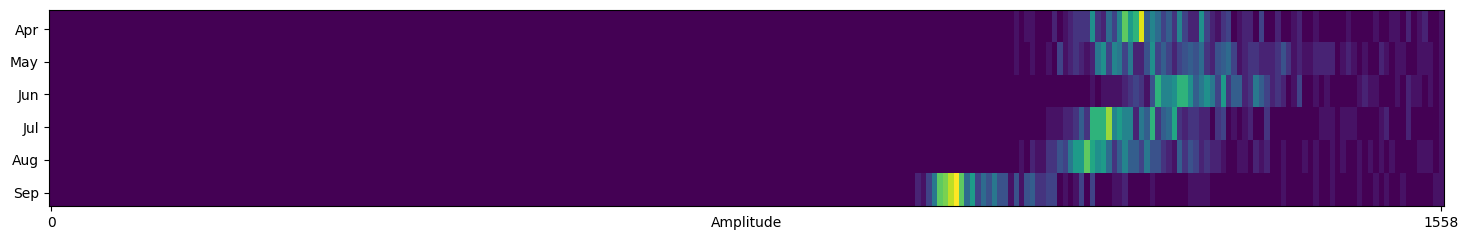

In [26]:
def plot_tick_format_hist(tick_val, tick_pos):
    print('plot_tick_format_hist')
    return int(tick_val * 10)

def plot_masked_band_hist(ax, masked_band, pixel_height=6, ylabels='all', bandmax=None):
    xmin = 0
    xmax = np.max(masked_band)
    month1 = masked_band[0]
    npix = month1[month1 != 0].size
    m2 = npix * 100

    #print(f'plot_masked_band_hist: shape={masked_band.shape}, type={masked_band.dtype}, band_max: {xmax}, npix: {npix}')
    cmap = plt.colormaps['jet']    
    nbins = 256
    hist = np.zeros((masked_band.shape[0]*pixel_height, nbins))
    for n in range(masked_band.shape[0]):
        __band_data = np.array(masked_band[n,:,:])
        if bandmax is None:
            hist[n*pixel_height:n*pixel_height+pixel_height], _ = np.histogram(__band_data, bins=nbins)
        else:
            hist[n*pixel_height:n*pixel_height+pixel_height], _ = np.histogram(__band_data, bins=nbins, range=(0,bandmax))
        hist[n*pixel_height:n*pixel_height+pixel_height,0] = 0
    #print('hist_height:', n*pixel_height+pixel_height)
    ymin = pixel_height / 2
    ymax = n * pixel_height + pixel_height - pixel_height / 2
    _ = ax.imshow(hist)
    if ylabels == 'firstlast':
        _ = ax.yaxis.set_major_locator(ticker.FixedLocator([ymin, ymax]))
        _ = ax.set_yticklabels(['Apr', 'Sept'])
    elif ylabels == 'all':
        _ = ax.yaxis.set_major_locator(ticker.FixedLocator(np.arange(masked_band.shape[0]) * pixel_height + pixel_height / 2))
        _ = ax.set_yticklabels(['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])
    else:
        _ = ax.set_yticks([])
        _ = ax.set_ylabel('month')
    _ = ax.xaxis.set_major_locator(ticker.FixedLocator([0, nbins-1]))
    if bandmax is None:
        _ = ax.set_xlabel(f'Amplitude', labelpad=-10)
    else:
        _ = ax.set_xlabel(f'Amplitude (max={xmax})', labelpad=-10)
        xmax = bandmax
    if xmax > 1000:
        _ = ax.set_xticklabels(['0', f'{xmax:.0f}'])
    elif xmax < 10:
        _ = ax.set_xticklabels(['0', f'{xmax:.2f}'])
    else:
        _ = ax.set_xticklabels(['0', f'{xmax:.1f}'])

fig, ax = plt.subplots(figsize=(18, 4))

patch1_B03_label330 = np.array(patch_data1['B03']['monthly'].copy())
label_mask = get_label_mask_from_idx(patch_data1, 0)
print(label_mask.shape)
patch1_B03_label330[:,label_mask == 0] = 0

_ = plot_masked_band_hist(ax, patch1_B03_label330)

B03 bandmax: 2814


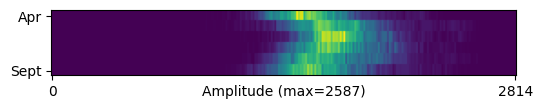

In [27]:
def get_multicrop_bandmax(masks, crop_labels, band):
    maxvals = []
    for label in crop_labels:
        dat = get_crop_pixels(masks, label, band)
        max = np.max(dat)
        #print('max:', max)
        maxvals.append(max)
    cropmax = np.max(maxvals)
    return cropmax

band = 'B03'
crop_list = frequent_crops.head()['label'].to_list()
bandmax = get_multicrop_bandmax(stacked_masks, crop_list, band)
print(f'{band} bandmax:', bandmax)

fig, ax = plt.subplots(figsize=(6,2))
dat = get_crop_pixels(stacked_masks, crop_list[0], band)
_ = plot_masked_band_hist(ax, dat, ylabels='firstlast', bandmax=bandmax)

In [28]:
masked_bands = stacked_masks[stacked_masks['label'] == 330]
masked_bands.head()

,label,band,masked_band,area,crop
0,330,B02,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",37056,Grapes
1,330,B03,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",37056,Grapes
2,330,B04,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",37056,Grapes
3,330,B08,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",37056,Grapes


band shape: (6, 1098, 366)


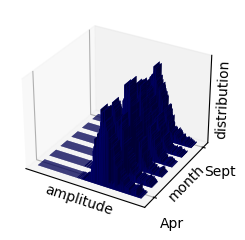

In [52]:
color_factor = 500
color_factor = 200
color_factor = 100
def plot_bar3d(ax, band):
    max = np.max(band)
    cmap = plt.colormaps['jet']
    nbins = 256
    print('band shape:', band.shape)
    for n in range(band.shape[0]):
        hist, _ = np.histogram(band[n,:,:], bins=nbins)
        hist = hist[1:]
        #print(hist)
        width = depth = 0.6
        z = np.zeros(hist.shape[0])
        #print(f'band shape: {band.shape}, dtype: {band.dtype}')
        rgba = [cmap((k-np.min(band))/np.max(band)/color_factor) for k in hist]
        #print(f'rgba (cmap args): {[((k-np.min(band))/np.max(band)*.002) for k in hist]}')
        #print(f'rgba (cmap args shape): {len([((k-np.min(band))/np.max(band)*.002) for k in hist])}')
        #print(f'rgba (cmap args[0]): ({hist[0]} - {np.min(band)}) / {np.max(band)} = {(hist[0] - np.min(band)) / np.max(band)*.002}')
        _ = ax.bar3d(np.arange(nbins-1), n, z, width, depth, hist, color=rgba, shade=True)
    _ = ax.set_xticks([])
    #_ = ax.set_yticks([])
    _ = ax.set_zticks([])
    _ = ax.set_ylabel('month')

    ymin = 0.5
    ymax = band.shape[0] - 0.5

    _ = ax.yaxis.set_major_locator(ticker.FixedLocator([ymin, ymax]))
    _ = ax.set_yticklabels(['Apr', 'Sept'])
    
    _ = ax.set_xlabel('amplitude')
    _ = ax.xaxis.labelpad=-15
    _ = ax.yaxis.labelpad=-15
    _ = ax.zaxis.labelpad=-15
    _ = ax.set_zlabel('distribution')    

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(121, projection='3d')
mb03 = masked_bands[masked_bands['band'] == 'B03']['masked_band'].to_numpy()[0]
mb03[mb03 == 0] = 1
plot_bar3d(ax, mb03)

Top 5 crops in by highest area: [330, 361, 975, 442, 353] / ['Grapes' 'Almonds' 'Fallow land' 'Olives' 'Cherries and sour cherries']
band shape: (6, 1098, 366)


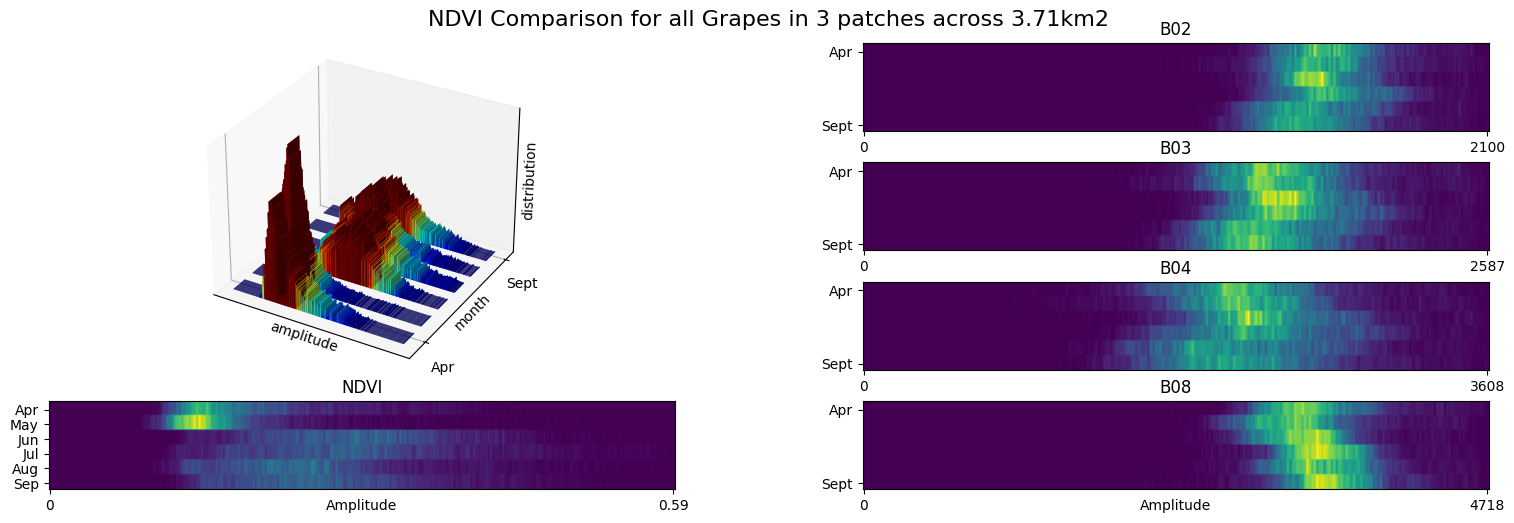

band shape: (6, 732, 366)


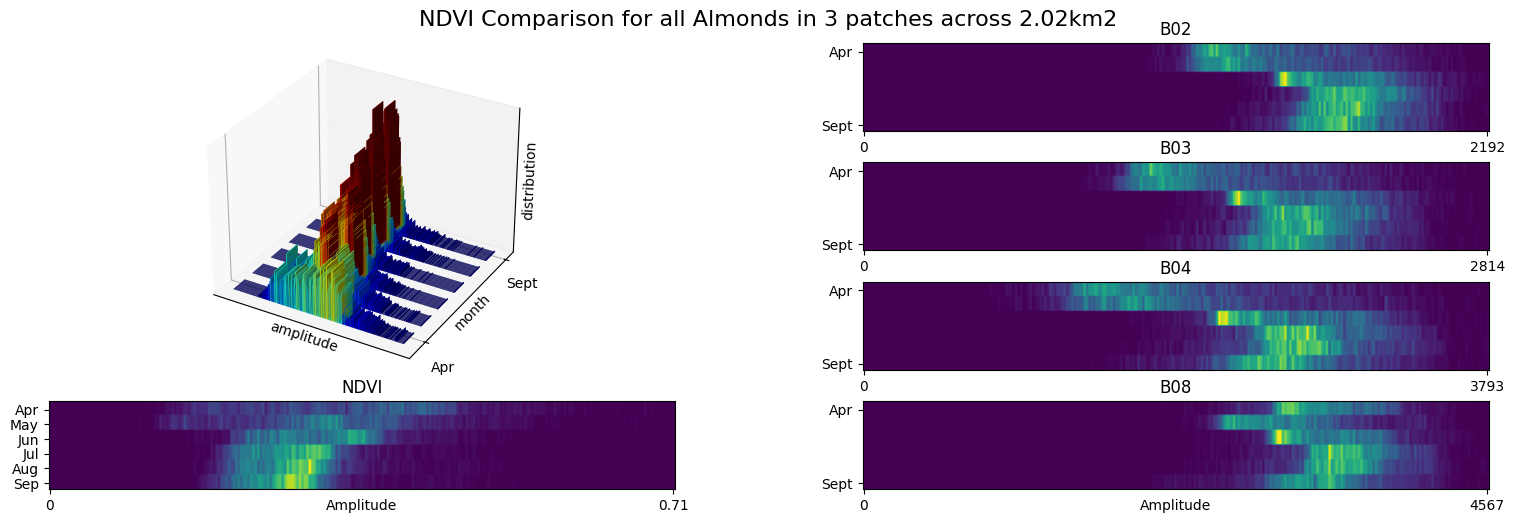

band shape: (6, 732, 366)


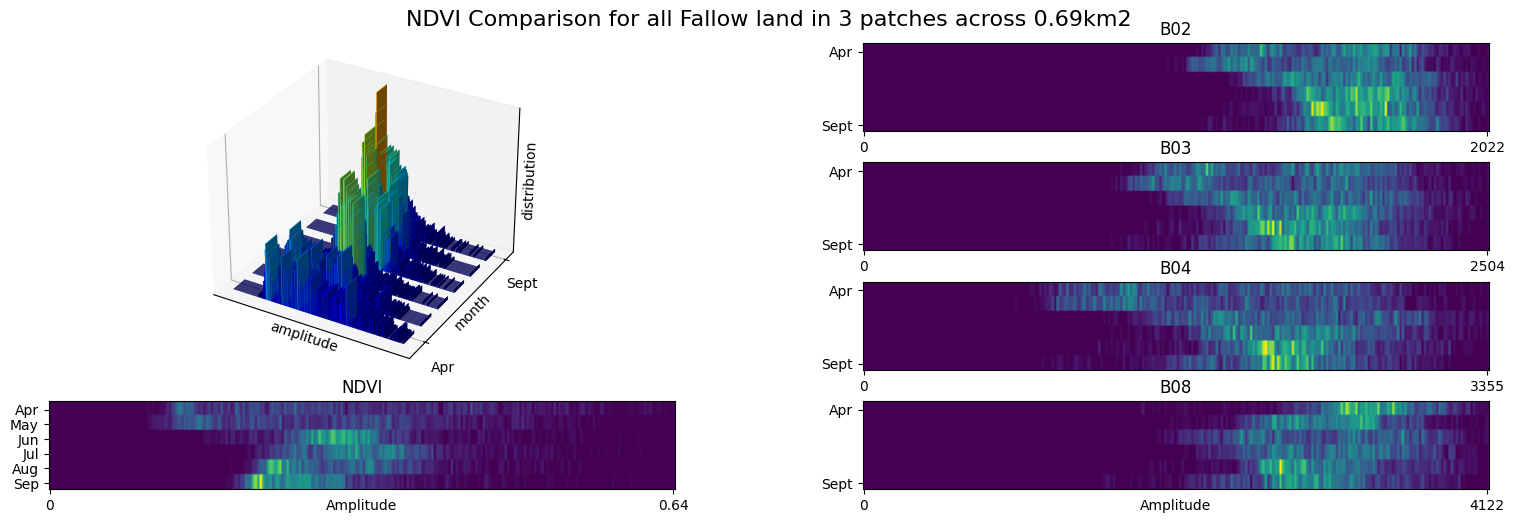

band shape: (6, 1098, 366)


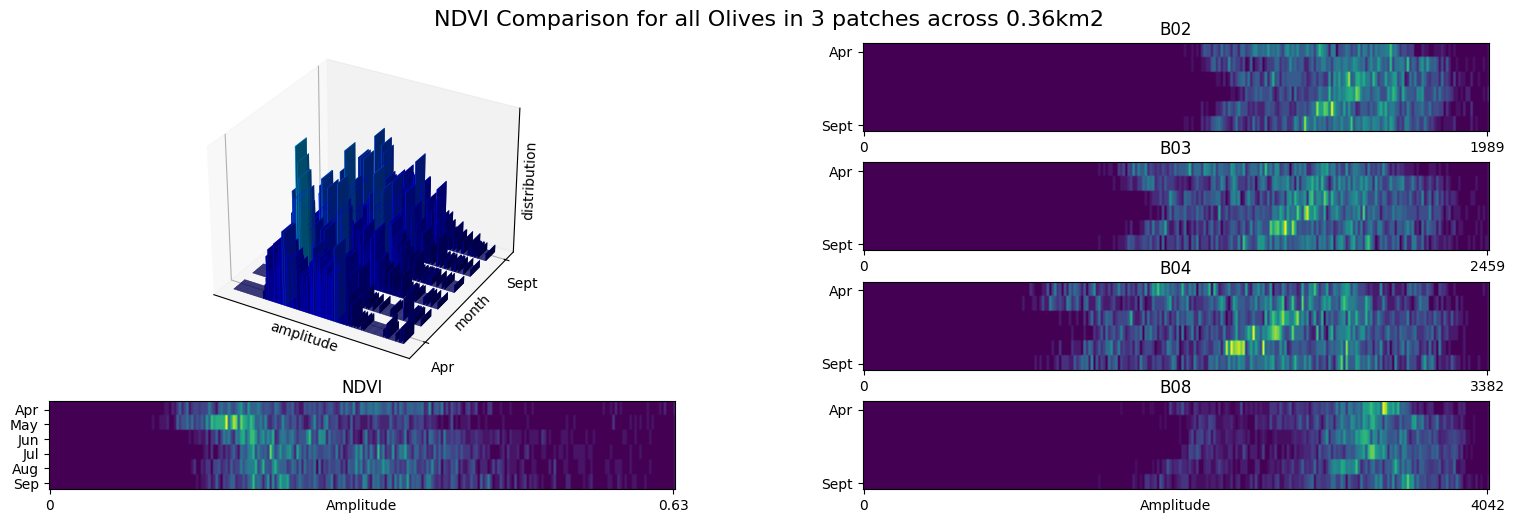

band shape: (6, 732, 366)


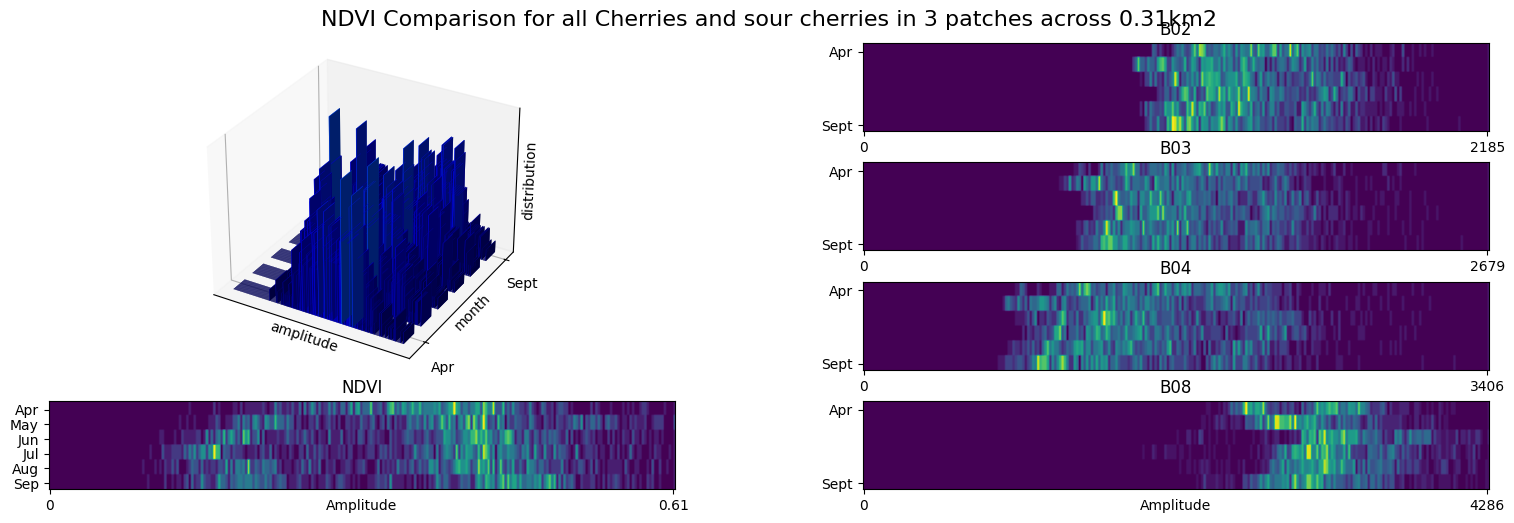

In [53]:
def plot_NDVI_hist2(masks, label):
    masked_bands = masks[masks['label'] == label]
    mb04 = masked_bands[masked_bands['band'] == 'B04']['masked_band'].to_numpy()[0]
    mb04[mb04 == 0] = 1
    mb08 = masked_bands[masked_bands['band'] == 'B08']['masked_band'].to_numpy()[0]
    mb08[mb08 == 0] = 1
    NDVI = (mb08 - mb04) / (mb08 + mb04)
    area = get_crop_area(masks, label)

    fig = plt.figure(figsize=(18, 5))
    fig.suptitle(f'NDVI Comparison for all {decode_label(label)} in {N} patches across {area:.2f}km2', fontsize=16, y=1.01)

    gs = gridspec.GridSpec(4,2, hspace=0.8)
    ax0 = fig.add_subplot(gs[0:3,0], projection='3d')
    _ = plot_bar3d(ax0, NDVI)
    
    ax1 = fig.add_subplot(gs[3,0])
    _ = plot_masked_band_hist(ax1, NDVI, ylabels='all')
    _ = ax1.set_title('NDVI')
    
    max = 0
    for n, band in enumerate(['B02', 'B03', 'B04', 'B08']):
        dat = get_crop_pixels(masks, label, band)
        ax20 = fig.add_subplot(gs[n,1])
        _ = plot_masked_band_hist(ax20, dat, ylabels='firstlast')
        _ = ax20.set_title(f'{band}')
        if band != 'B08':
            _ = ax20.set_xlabel('')
        max = np.max([max, np.max(dat)])
    gs.update(left=0.1,right=0.9,top=0.965,bottom=0.03,wspace=0.3,hspace=0.09)
    plt.show()

print(f'Top 5 crops in by highest area: {crop_list} / {decode_labels(crop_list)}')
for crop_label in crop_list:
    plot_NDVI_hist2(stacked_masks, crop_label)